In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config, Simulation
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

In [2]:
print(os.getcwd())

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks


## Parameters

#### Lorenz attractor simulation parameters

We simulate here 9 different possible Lorenz attractor configurations, essentially modifying the parameter $r$ that governs the behavior of the system. 

As a reminder, here is how the behavior of the system is affected by the parameter $r$:

- $0<r<1$ : 1 stable attractor
- $1<r<\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 2 stable attractors
- $r>\sigma \frac{\sigma + \beta + 3}{\sigma - \beta - 1}$ : 3 unstable attractors

For each of the three cases above, we chose to take 3 Lorenz configurations. For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

In [3]:
config = load_config('../config.yaml')

# Define parameters
dt = 0.01
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']
orders = config['simulations']['order']

## Simulation

Here we simulate all possible Lorenz traces according to the parameters mentioned above

In [4]:
simulations = []
for condition in lorenz_parameters:
    for i in range(len(lorenz_parameters[condition])):
        sim = Simulation(num_samples, num_steps, dt)
        pattern = lorenz_parameters[condition][i]
        sim.simulation_lorenz(pattern)
        simulations.append(sim)

In [5]:
simulations

In [6]:
simulations[8].simulation

array([[[0.33790758, 0.33758014, 0.34273284],
        [0.33787484, 0.33794923, 0.3425844 ],
        [0.33788228, 0.33829874, 0.34244033],
        ...,
        [0.28007268, 0.25859056, 0.58931266],
        [0.27792447, 0.25427042, 0.5898869 ],
        [0.27555906, 0.24985667, 0.59113711]],

       [[0.33873971, 0.34261224, 0.34091492],
        [0.33912696, 0.3431388 , 0.34083537],
        [0.33952815, 0.34385182, 0.34076246],
        ...,
        [0.25452803, 0.23187328, 0.63456481],
        [0.25226256, 0.2316032 , 0.64094967],
        [0.25019662, 0.23218732, 0.64759204]],

       [[0.33790422, 0.3432537 , 0.33893502],
        [0.33843917, 0.34343158, 0.3388994 ],
        [0.33893841, 0.34387389, 0.33887015],
        ...,
        [0.25733109, 0.24962903, 0.6447296 ],
        [0.25656089, 0.25083793, 0.64807118],
        [0.25598859, 0.25248123, 0.6512742 ]],

       ...,

       [[0.3413212 , 0.34315807, 0.34140666],
        [0.34150489, 0.34483405, 0.34134142],
        [0.34183781, 0

In [7]:
# create new simulations average list which contains average each element of simulations over first dimension
simulations_average = []
for i in range(len(simulations)):
    average_sim = np.mean(simulations[i].simulation, axis=0)
    simulations_average.append(np.broadcast_to(average_sim, (num_samples, num_steps,3)))

## Visualization

Visualization of one of the $200$ possible initializations for each of the nine possible Lorenz configurations

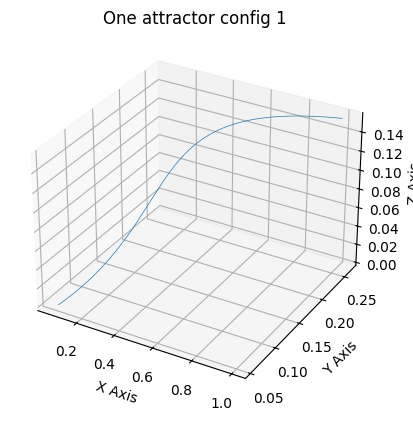

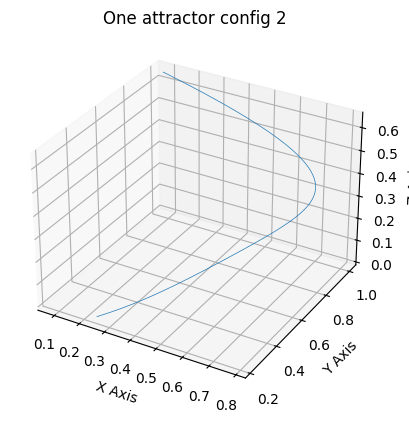

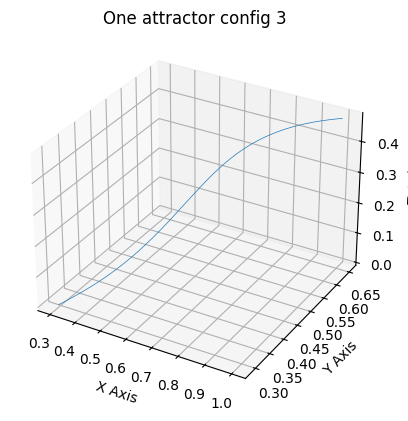

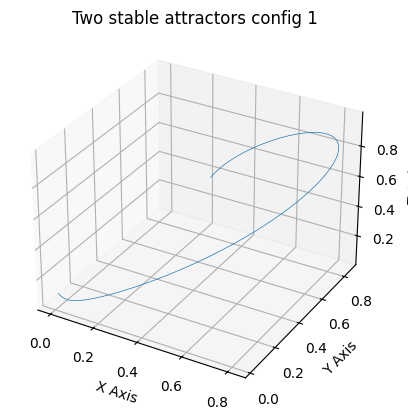

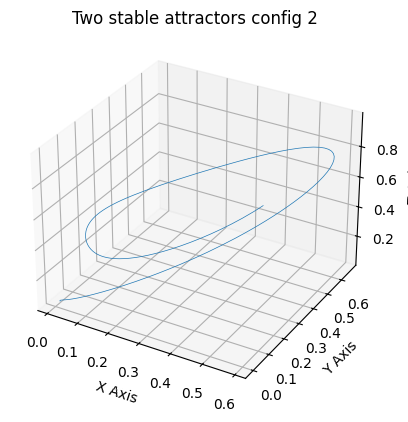

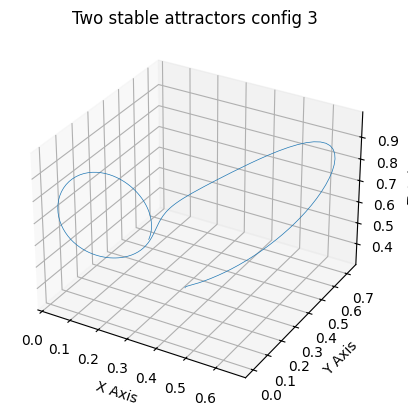

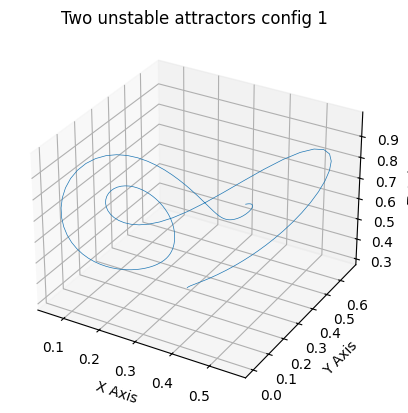

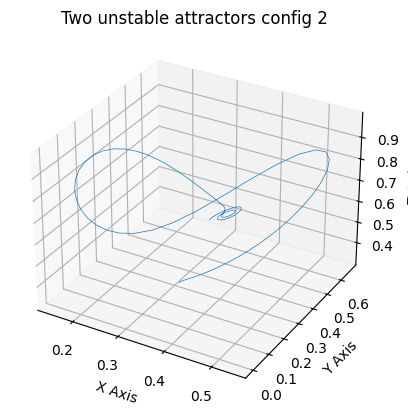

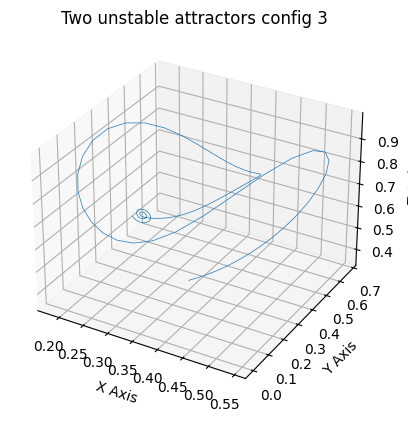

In [8]:
model = [simulations[i].simulation[50,:,:] for i in range(9)]
# model = [simulations_average[i] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])
   plt.show()
   

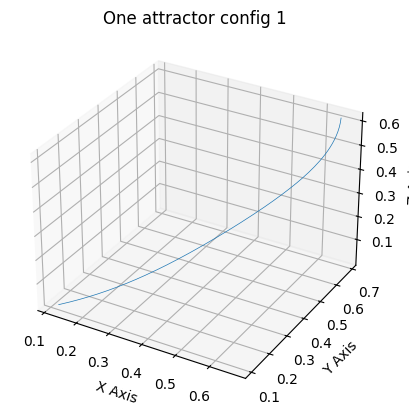

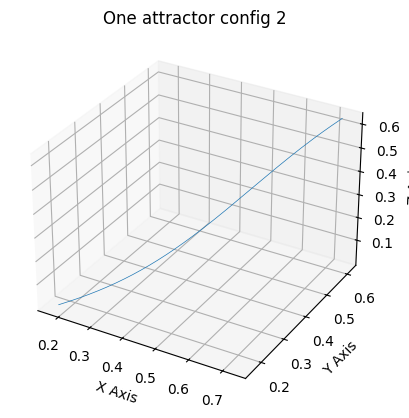

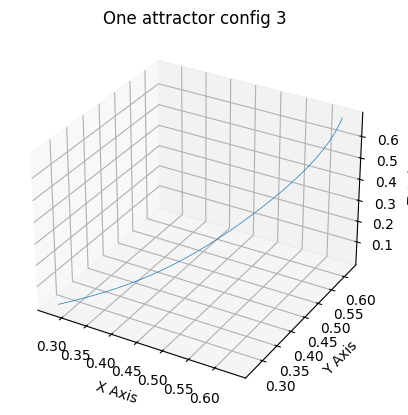

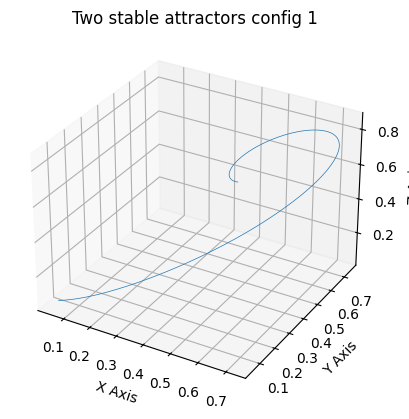

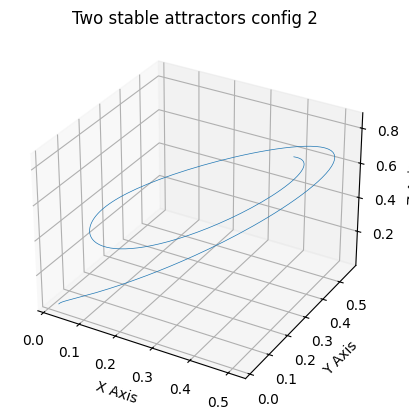

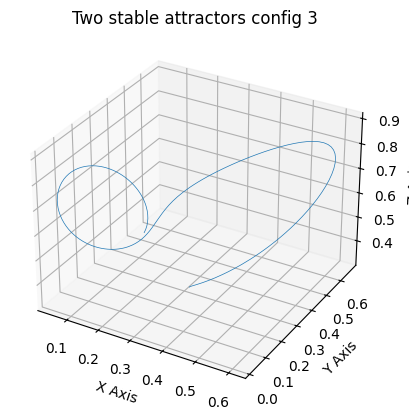

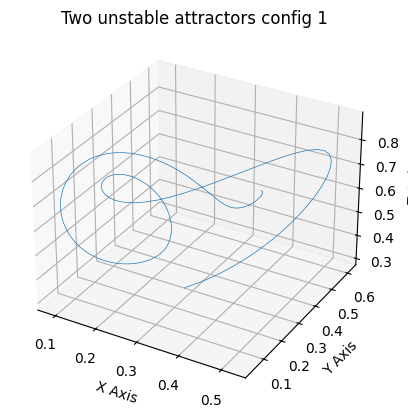

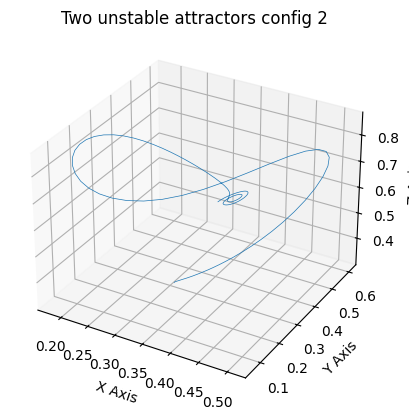

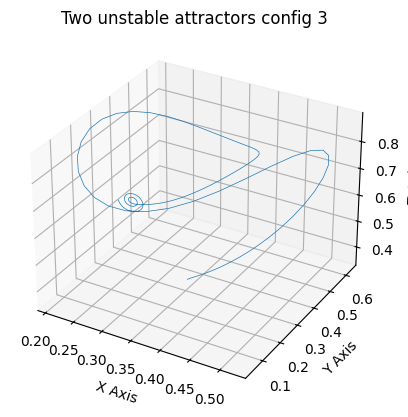

In [9]:
model = [simulations_average[i][50,:,:] for i in range(9)]
model_names = ['One attractor config 1', 'One attractor config 2', 'One attractor config 3','Two stable attractors config 1', 'Two stable attractors config 2', 'Two stable attractors config 3', 'Two unstable attractors config 1', 'Two unstable attractors config 2', 'Two unstable attractors config 3']


for i in range(len(model)):
   fig = plt.figure()
   ax = fig.add_subplot(projection='3d')
   xyzs = model[i]
   to_plot = xyzs
   # Plot trajectory of first 
   ax.plot(*to_plot.T, lw=0.5)
   
   # ax.scatter(*fourth, color='black')
   ax.set_xlabel("X Axis")
   ax.set_ylabel("Y Axis")
   ax.set_zlabel("Z Axis")
   ax.set_title(model_names[i])

   plt.show()

## DSA analysis

Computations of the similarity metric between each of the 9 possible configurations, according to [1]

In [10]:
model = [simulations[i].simulation for i in range(9)]
# model = [simulations_average[i] for i in range(9)]

In [11]:
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")

In [12]:
procrustes_scores = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        procrustes_scores[i,j] = procrustes_measure(model[i],model[j])
procrustes_scores = 1 - procrustes_scores

In [13]:
cka_measure = similarity.make(
    "measure.sim_metric.cka-angular-score"
)
cka_scores = np.empty((len(model), len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        cka_scores[i, j] = cka_measure(model[i], model[j])
cka_scores = 1 - cka_scores

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.34129949168729246 1.2224972709239472 0.6587005083127075
arccos score: 0.2564541840401673 1.3114444232356322 0.7435458159598327
arccos score: 0.4186008982797774 1.1388921266870788 0.5813991017202226
arccos score: 0.1464665932813588 1.423800934423693 0.8535334067186412
arccos score: 0.30794771790996345 1.2577611601989274 0.6920522820900366
arccos score: 0.10249089521681398 1.4681251441106702 0.897509104783186
arccos score: 0.12694822404579797 1.4435046261439617 0.873051775954202
arccos score: 0.15510707453181682 1.4150604881140225 0.8448929254681832
arccos score: 0.34129949168729246 1.2224972709239472 0.6587005083127075
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.16355823484644727 1.4064999385427743 0.8364417651535527
arccos score: 0.32953155177750304 1.2349889561718672 0.670468448222497
arccos score: 0.1250486803400943 1.4454194303042533 0.8749513196599057
arccos score: 0.23969975550503975 1.32873974

In [14]:
dsa = DSA.DSA(model,n_delays=config['dsa']['n_delays'],rank=20,delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
dsa_scores = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

### Heatmap

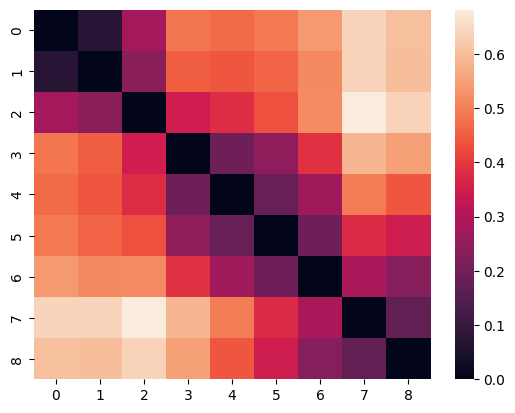

In [15]:
sns.heatmap(dsa_scores)
plt.show()

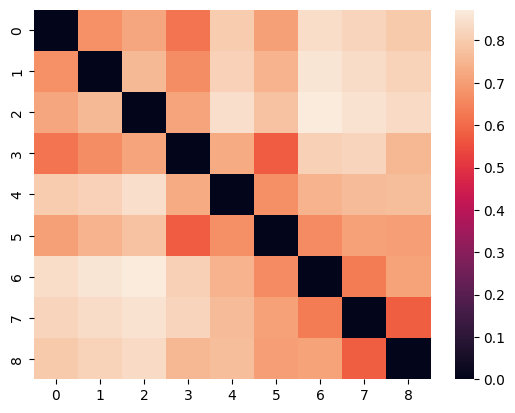

In [16]:
sns.heatmap(procrustes_scores)
plt.show()

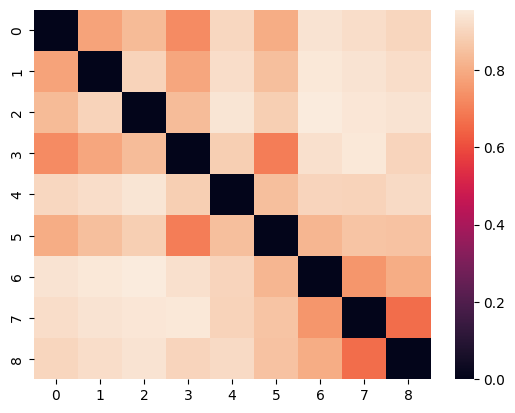

In [17]:
sns.heatmap(cka_scores)
plt.show()

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 